In [2]:
import re
import os
import re
import glob
import shutil
import subprocess
import nibabel as nib
from nipype.interfaces.dcm2nii import Dcm2niix
from fsl.wrappers import bet, flirt, fslmaths
import numpy as np
import matplotlib
from scipy.ndimage import zoom
import SimpleITK as sitk
from scipy.optimize import least_squares,minimize
import matplotlib.pyplot as plt

In [4]:
def process_dicom_to_deltaB0(dicom_directory, nifti_folder, delta_TE, Frequency):
    """
    Converts DICOM files to NIfTI format, performs phase unwrapping, applies a brain mask, and calculates delta B0 maps.

    Parameters:
        dicom_directory (str): Path to the directory containing DICOM files.
        nifti_folder (str): Path to the directory where NIfTI files will be saved.
        delta_TE (float): Echo time difference in seconds.
        Frequency (float): Scanner frequency in MHz (e.g., 127.74 MHz for a 3T scanner).
    """
    print("启动！")
    directories = os.listdir(dicom_directory)

    for directory in directories:
        try:
            dicom_file_path = os.path.join(dicom_directory, directory)
            nifti_file_path = os.path.join(nifti_folder, f"{directory}_nii")
            os.makedirs(nifti_file_path, exist_ok=True)

            # Convert DICOM to NIfTI format
            converter = Dcm2niix()
            converter.inputs.source_dir = dicom_file_path
            converter.inputs.output_dir = nifti_file_path
            converter.run()
            # Identify phase and magnitude images
            phase_map = glob.glob(os.path.join(nifti_file_path, "*ph.nii.gz*"))
            magnitude_map = glob.glob(os.path.join(nifti_file_path, "*e2.nii.gz*"))

            if phase_map and magnitude_map:
                # Load the phase image and normalize it to range [-π, π]
                phase_map_nifti = nib.load(phase_map[0])
                phase_map_data = phase_map_nifti.get_fdata()
                affine = phase_map_nifti.affine.copy()
                header = phase_map_nifti.header.copy()

                phasemap = phase_map_data / 4096 * np.pi
                phase_map_img_valid = nib.Nifti1Image(phasemap, affine, header)
                phase_map_img_valid_path = os.path.join(nifti_file_path, f"{directory}_PhaseMap.nii.gz")
                nib.save(phase_map_img_valid, phase_map_img_valid_path)

                # Generate brain mask using BET (Brain Extraction Tool)
                bet_path = os.path.join(nifti_file_path, f"{directory}_bet.nii.gz")
                bet(magnitude_map[0], bet_path, f=0.5, m=True)

                # Apply the brain mask to the phase image
                mask_path = os.path.join(nifti_file_path, f"{directory}_bet_mask.nii.gz")
                brain_map_path = os.path.join(nifti_file_path, f"{directory}_BrainMap.nii.gz")
                fslmaths(phase_map_img_valid_path).mul(mask_path).run(brain_map_path)

                # Perform phase unwrapping
                unwrap_path = os.path.join(nifti_file_path, f"{directory}_unwrapped_Brain.nii.gz")
                cmd = [
                    "prelude",
                    "-p", brain_map_path,
                    "-a", magnitude_map[0],
                    "-o", unwrap_path
                ]
                subprocess.run(cmd, check=True)

                # Calculate delta B0 in Hz
                deltB0_hertz_path = os.path.join(nifti_file_path, f"{directory}_deltaB0_hertz.nii.gz")
                fslmaths(unwrap_path).div(2).div(np.pi).div(delta_TE).run(deltB0_hertz_path)

                # Calculate delta B0 in ppm
                deltB0_ppm_path = os.path.join(nifti_file_path, f"{directory}_deltaB0_ppm.nii.gz")
                fslmaths(deltB0_hertz_path).div(Frequency).run(deltB0_ppm_path)

                print(f"Processing completed for {directory}")
            else:
                print(f"Phase or magnitude images not found for {directory}")
        
        except Exception as e:
            print(f"Error processing {directory}: {e}")

In [5]:
# Parameters for delta B0 calculation
delta_TE = 0.00246  # Echo time difference in seconds
Frequency = 42.58 * 3  # Scanner frequency in MHz for 5T
infant_dicom = r"./ref_test_dicom"
infant_nii = r"./ref_test_nii"
process_dicom_to_deltaB0(infant_dicom, infant_nii, delta_TE, Frequency)

启动！
250410-00:57:20,951 nipype.interface INFO:
	 stdout 2025-04-10T00:57:20.951810:Chris Rorden's dcm2niiX version v1.0.20220720  (JP2:OpenJPEG) GCC13.2.0 x86-64 (64-bit Linux)
250410-00:57:20,952 nipype.interface INFO:
	 stdout 2025-04-10T00:57:20.951810:Found 300 DICOM file(s)
250410-00:57:20,953 nipype.interface INFO:
	 stdout 2025-04-10T00:57:20.951810:Convert 100 DICOM as ref_test_nii/ref_nii/ref_gre_B0_map_20250409192801_303_ph (90x90x100x1)
250410-00:57:20,984 nipype.interface INFO:
	 stdout 2025-04-10T00:57:20.984214:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "ref_test_nii/ref_nii/ref_gre_B0_map_20250409192801_303_ph.nii"
250410-00:57:20,984 nipype.interface INFO:
	 stdout 2025-04-10T00:57:20.984214:Convert 100 DICOM as ref_test_nii/ref_nii/ref_gre_B0_map_20250409192801_302_e2 (90x90x100x1)
250410-00:57:21,46 nipype.interface INFO:
	 stdout 2025-04-10T00:57:21.046920:Compress: "/usr/bin/pigz" -b 960 -n -f -6 "ref_test_nii/ref_nii/ref_gre_B0_map_20250409192801_302_e2.nii"
250410-

In [8]:
# 加载目标场图（单位 Hz）
# -------------------------
target_nii = nib.load(r"./ref_test_nii/ref_nii/ref_deltaB0_hertz.nii.gz")
B0_target = target_nii.get_fdata()
# target_slice = 30 
target_shape = B0_target.shape
b = B0_target.flatten()

# -------------------------
# 加载 coil profile（每通道的场分布）
# -------------------------
nifti_folder = r'./32ch_coil_profile_nii'
B0_list = []
folder =sorted(os.listdir(nifti_folder))

def natural_key(s):

    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

sorted_channels = sorted(os.listdir(nifti_folder), key=natural_key)

for ch_name in sorted_channels:
    delta_path = os.path.join(nifti_folder, ch_name, f"{ch_name}_deltaFieldmap.nii")
    if os.path.exists(delta_path):
        img = nib.load(delta_path)
        B0_ch = img.get_fdata()
        B0_slice = B0_ch
        B0_list.append(B0_slice)

B0_array = np.stack(B0_list, axis=-1)
A = B0_array.reshape(-1, B0_array.shape[-1])

# -------------------------
# 最小二乘拟合电流
# -------------------------


def loss_mse(w):
    residual = A @ w + b
    return np.mean(residual ** 2)  # MSE
# def loss_peak_to_peak(w):
#     residual = A @ w + b
#     return np.ptp(residual)  
# def loss_max_residual(w):
#     residual = A @ w + b
#     return np.max(np.abs(residual))

bounds = [(-4.0, 4.0)] * A.shape[1]
initial_weights = np.ones(A.shape[1]) / A.shape[1]
result = minimize(loss_mse, initial_weights, bounds=bounds)
shim_currents = result.x  # 单位：A

# -------------------------
# 输出结果到文本文件
# -------------------------
output_path = "shim_currents.txt"
with open(output_path, "w") as f:

    for idx, current in enumerate(shim_currents):
        f.write(f" {current:.3f},")

# 同时打印在终端
print("动态匀场电流分布（单位 A）：")
for idx, current in enumerate(shim_currents):
    print(f"ch{idx+1}: {current:.3f}A")

动态匀场电流分布（单位 A）：
ch1: 0.035A
ch2: -0.618A
ch3: -0.572A
ch4: -0.907A
ch5: -0.110A
ch6: -0.163A
ch7: -0.383A
ch8: -0.215A
ch9: -0.115A
ch10: -0.172A
ch11: -0.185A
ch12: -0.032A
ch13: 0.034A
ch14: -0.064A
ch15: -0.632A
ch16: -0.166A
ch17: -0.274A
ch18: -0.869A
ch19: -0.347A
ch20: -0.631A
ch21: 0.089A
ch22: -0.002A
ch23: -0.098A
ch24: 0.011A
ch25: -0.047A
ch26: 0.181A
ch27: -0.213A
ch28: -0.046A
ch29: -0.114A
ch30: 0.060A
ch31: -0.115A
ch32: 0.122A


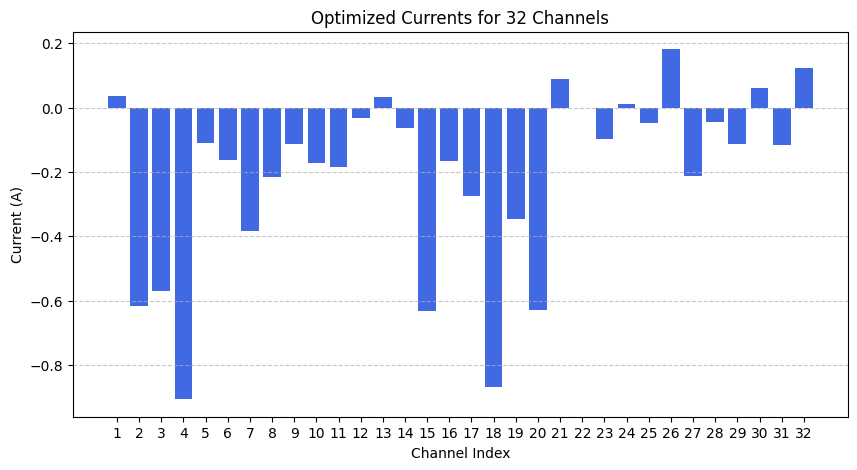

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(shim_currents) + 1), shim_currents, color='royalblue')

plt.xlabel("Channel Index")
plt.ylabel("Current (A)")
plt.title("Optimized Currents for 32 Channels")
plt.xticks(range(1, len(shim_currents) + 1)) 

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

/tmp/ipykernel_2859861/2871879963.py:16: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2859861/2871879963.py:16: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2859861/2871879963.py:16: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2859861/2871879963.py:16: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2859861/2871879963.py:16: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2859861/2871879963.py:16: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2859861/2871879963.py:16: UserWarning: Glyph 21512 (\N{CJK UN

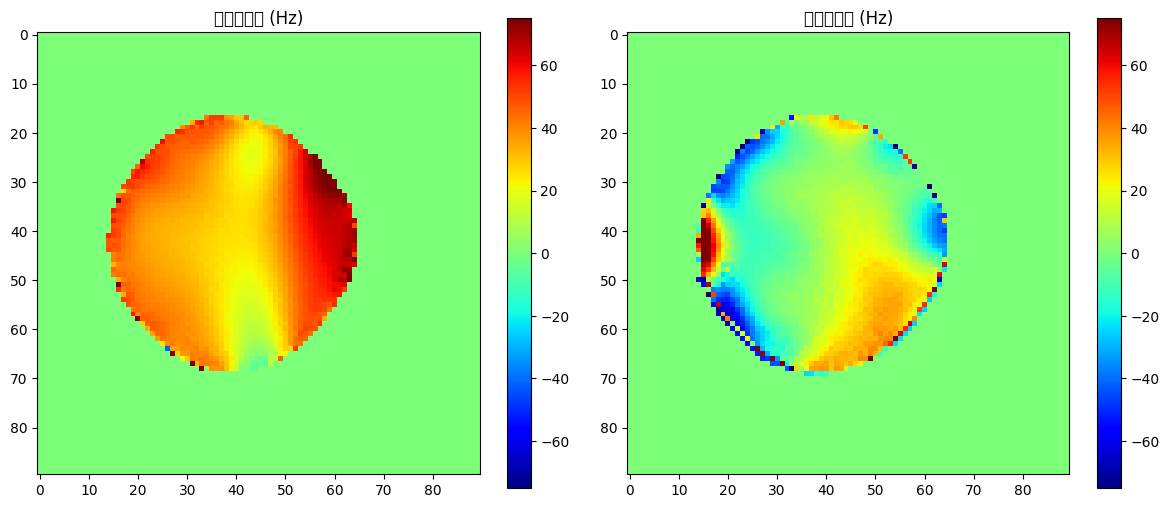

In [12]:
# 重构拟合后的场图
B0_fitted = ( A @ shim_currents ).reshape(target_shape)
B0_fitted = B0_fitted + B0_target
# 可视化某一层 slice 对比
norm = matplotlib.colors.Normalize(vmin=-75, vmax=75)
slice_idx = 80
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(B0_target[:, :, slice_idx], cmap='jet',norm=norm)
plt.title("原目标场图 (Hz)")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(B0_fitted[:, :, slice_idx], cmap='jet', norm=norm)
plt.title("拟合后场图 (Hz)")
plt.colorbar()
plt.tight_layout()
plt.show()


In [1]:
import os, re
import numpy as np
import nibabel as nib
from scipy.optimize import minimize

target_nii = nib.load("./nii_infant/infant_brain_nii/infant_brain_deltaB0_hertz.nii.gz")
B0_target = target_nii.get_fdata() * 1e6
b = B0_target.flatten()
target_shape = B0_target.shape

nifti_folder = r'./32ch_coil_profile_nii'
def natural_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]
sorted_channels = sorted(os.listdir(nifti_folder), key=natural_key)

B0_list = []
for ch_name in sorted_channels:
    delta_path = os.path.join(nifti_folder, ch_name, f"{ch_name}_Regis_deltB0.nii.gz")
    if os.path.exists(delta_path):
        img = nib.load(delta_path)
        B0_ch = img.get_fdata()
        B0_list.append(B0_ch)

B0_array = np.stack(B0_list, axis=-1)
A = B0_array.reshape(-1, B0_array.shape[-1])

n_channels = A.shape[1]
initial_weights = np.ones(n_channels) / n_channels
bounds = [(-4.0, 4.0)] * n_channels  

def loss_mse(w):  # L2 范数
    return np.mean((A @ w + b) ** 2)

def loss_l1(w):  # L1 范数
    return np.mean(np.abs(A @ w + b))

def loss_max(w):  # 最大绝对残差
    return np.max(np.abs(A @ w + b))

def loss_ptp(w):  # peak to peak
    r = A @ w + b
    return r.max() - r.min()

loss_dict = {
    "MSE (L2)": loss_mse,
    "L1": loss_l1,
    "Max Error": loss_max,
    "Peak-to-Peak": loss_ptp,
}

results = {}

for name, loss_func in loss_dict.items():
    print(f"\n>>> 正在拟合目标函数: {name}")
    res = minimize(loss_func, initial_weights, bounds=bounds, method='L-BFGS-B')
    shim_currents = res.x
    residual = A @ shim_currents + b

    results[name] = {
        'currents': shim_currents,
        'residual': residual,
        'loss': loss_func(shim_currents)
    }

for name, data in results.items():
    print(f"\n====== {name} ======")
    print(f"Loss: {data['loss']:.3f}")
    for idx, val in enumerate(data['currents']):
        print(f"ch{idx+1:02d}: {val:.3f} A")

with open("shim_currents_multiobj.txt", "w") as f:
    for name, data in results.items():
        f.write(f"### {name} ###\n")
        for idx, val in enumerate(data['currents']):
            f.write(f"ch{idx+1:02d}: {val:.3f} A\n")
        f.write("\n")


FileNotFoundError: No such file or no access: 'nii_infant/infant_brain_nii/infant_brain_deltaB0_hertz.nii.gz'

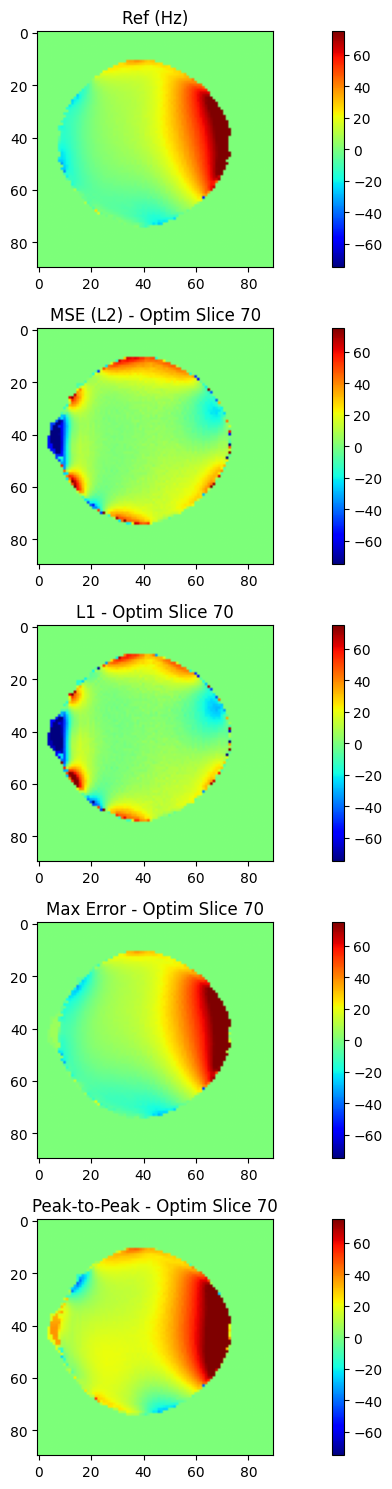

In [15]:
# -----------------------------
slice_id = 70  # 可改为你感兴趣的切片

plt.figure(figsize=(12, 3 * (len(results) + 1)))

# 原始目标场
plt.subplot(len(results) + 1, 1, 1)
plt.imshow(B0_target[:, :, slice_id], cmap='jet', vmin=-75, vmax=75)
plt.title("Ref (Hz)")
plt.colorbar()

# 拟合后的残差图
for i, (name, data) in enumerate(results.items()):
    res_3d = data['residual'].reshape(target_shape)
    plt.subplot(len(results) + 1, 1, i + 2)
    plt.imshow(res_3d[:, :, slice_id], cmap='jet', vmin=-75, vmax=75)
    plt.title(f"{name} - Optim Slice {slice_id}")
    plt.colorbar()

plt.tight_layout()
plt.show()

In [54]:
# 比较标准差和 peak-to-peak
std = np.std(residual)
ptp = residual.max() - residual.min()
print(f"Standard Deviation: {std:.3f} Hz, Peak-to-Peak: {ptp:.3f} Hz")


Standard Deviation: 49.277 Hz, Peak-to-Peak: 601.629 Hz


In [10]:
B0_opt_img = nib.Nifti1Image(B0_fitted, target_nii.affine)
nib.save(B0_opt_img, "B0_optimized.nii.gz")
fslmaths("./B0_optimized.nii.gz").mul("./ref_test_nii/ref_nii/ref_bet_mask.nii.gz").run("B0_optimized_mask.nii.gz")

{}

In [11]:
# 目标场图
target_nii = nib.load(r"./ref_test_nii/ref_nii/ref_deltaB0_hertz.nii.gz") 
B0_target = target_nii.get_fdata()
B0_regis = nib.load(r"./ref_test_nii/as_nii/as_deltaB0_hertz.nii.gz")
B0_regis_data = B0_regis.get_fdata()
print(np.std(B0_target))
print(np.std(B0_regis_data))

45.32674987004176
18.396046680250894


In [12]:
# Apply Gaussian smoothing to sham data
# sham_data = gaussian_filter(B0_target, sigma=0.2)
sham_data = B0_target
sham_data[sham_data == 0] = np.nan
sham_data = np.transpose(sham_data, (1, 0, 2))

# Apply Gaussian smoothing to shim data
# shim_data = gaussian_filter(B0_regis_data, sigma=0.2)
shim_data = B0_regis_data
shim_data[shim_data == 0] = np.nan
shim_data = np.transpose(shim_data, (1, 0, 2))

norm = matplotlib.colors.Normalize(vmin=-100, vmax=100)

fig, axs = plt.subplots(10, 20, figsize=(40, 40), dpi=500, sharex=True, sharey=True)
axs = axs.ravel() 
len_slices = np.size(sham_data, 2)

for i in range(len_slices):
    im = axs[i * 2].imshow(sham_data[:, :, i], cmap='jet', norm=norm)
    axs[i * 2].set_title(f'Sham {i + 1}')
    axs[i * 2].invert_yaxis()
    axs[i * 2].set_axis_off()

    axs[i * 2 + 1].imshow(shim_data[:, :, i], cmap='jet', norm=norm)
    axs[i * 2 + 1].set_title(f'Shim {i + 1}')
    axs[i * 2 + 1].invert_yaxis()
    axs[i * 2 + 1].set_axis_off()

cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02]) 
colorbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal' )
colorbar.ax.tick_params(labelsize=30) 
colorbar.set_label("Field map (Hz)",fontsize = 30)
plt.tight_layout(rect=[0, 0.1, 1, 1]) 
plt.savefig('B0_map(ppm).png')
plt.close()


/tmp/ipykernel_104358/4253857704.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])


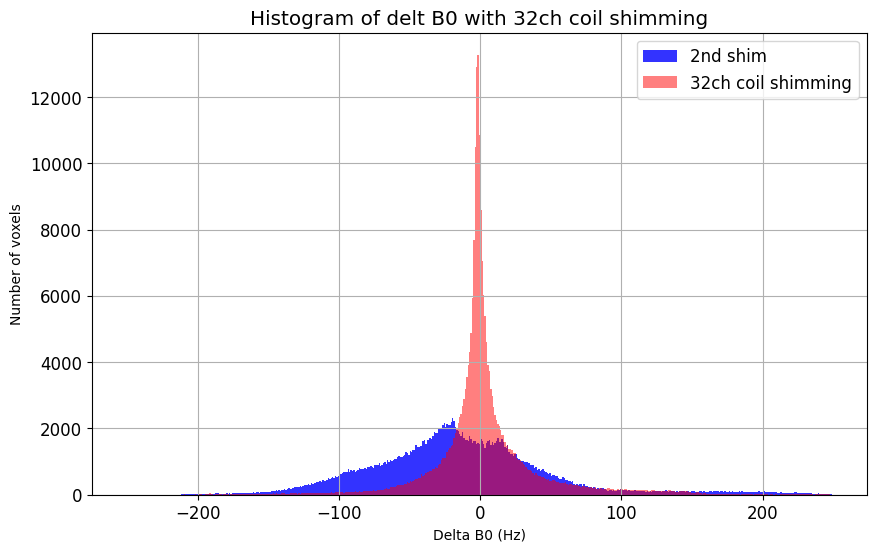

In [2]:
unshimmed_data = nib.load(r'./ref_test_nii/ref_nii/ref_deltaB0_hertz.nii.gz')
unshimmed_data = unshimmed_data.get_fdata()
unshimmed_data_nan = np.where(unshimmed_data == 0, np.nan, unshimmed_data)
unshimmed_values = unshimmed_data_nan[~np.isnan(unshimmed_data_nan)] 

shimmed_data = nib.load(r'./B0_optimized.nii.gz')
shimmed_data = shimmed_data.get_fdata()
shimmed_data_nan = np.where(shimmed_data == 0, np.nan, shimmed_data)
shimmed_values = shimmed_data_nan[~np.isnan(shimmed_data_nan)]

plt.figure(figsize=(10, 6),dpi = 100)
plt.hist(unshimmed_values.flatten(), bins=np.arange(-250, 250, 1), color='blue', alpha=0.8, label='2nd shim')
plt.hist(shimmed_values.flatten(), bins=np.arange(-250, 250, 1), color='red', alpha=0.5, label='32ch coil shimming')
# plt.hist(values_coil_shimming.flatten(), bins=np.arange(-2, 2.05, 0.02), color='red', alpha=0.4, label='coil_shimming')
plt.rcParams.update({'font.size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of delt B0 with 32ch coil shimming')
plt.xlabel('Delta B0 (Hz)')
plt.ylabel('Number of voxels')
plt.legend()
plt.grid(True)
plt.show()



['optim']


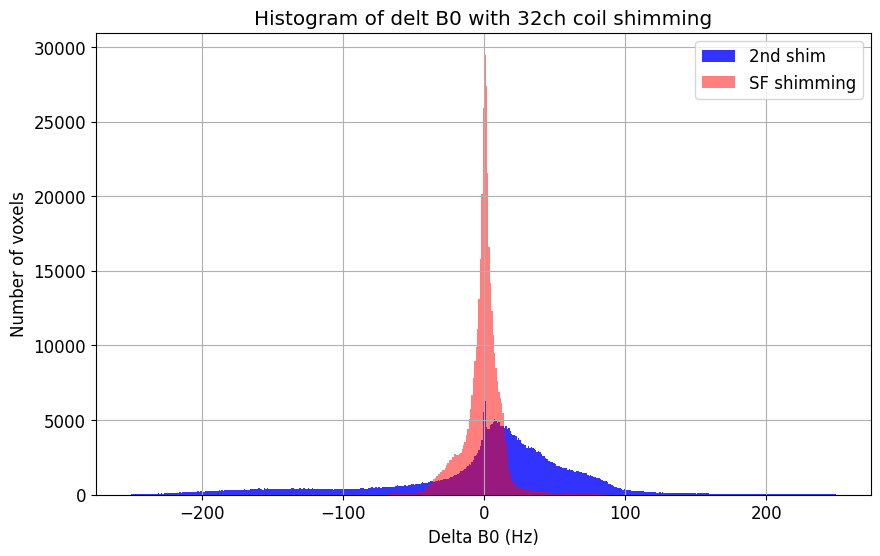

0.15857244535052628


In [3]:
import scipy.io as sio
import h5py
unshimmed_data = sio.loadmat("B0_map_valid.mat")['B0_data'] * 5 * 42.58

# 打开 v7.3 的mat文件
with h5py.File('optim_sf.mat', 'r') as f:
    print(list(f.keys()))  # 先列出里面的变量名

    data = f['optim']   # 取出来
    shimmed_data = np.array(data)  * 5 * 42.58      # 转成numpy array

plt.figure(figsize=(10, 6),dpi = 100)
plt.hist(unshimmed_data.flatten(), bins=np.arange(-250, 250, 1), color='blue', alpha=0.8, label='2nd shim')
plt.hist(shimmed_data.flatten(), bins=np.arange(-250, 250, 1), color='red', alpha=0.5, label='SF shimming')
# plt.hist(values_coil_shimming.flatten(), bins=np.arange(-2, 2.05, 0.02), color='red', alpha=0.4, label='coil_shimming')
plt.rcParams.update({'font.size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Histogram of delt B0 with 32ch coil shimming')
plt.xlabel('Delta B0 (Hz)')
plt.ylabel('Number of voxels')
plt.legend()
plt.grid(True)
plt.show()

print(1- np.std(unshimmed_data- shimmed_data) / np.std(unshimmed_data))